In [1]:
import pandas as pd
import numpy as np# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 전체 다 보이게 옵션 지정
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("/home/piai/PB/2. Big Data 분석/SCALE불량.csv",encoding="euc-kr")
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


### 데이터 전처리
1. plate number 제거(index와 동일)
2. rolling_date를 date(03JAN2023)와 time(07:07:53) 꼴로 파생변수 생성, 기존 rolling_date 삭제
3. 단위 제거(1호기, 1열, 1조) & 수치형 변환
4. 범주형 -> 수치형 변환
    - scale : 양품(0), 불량품(1)
    - hsb : 적용(0), 미적용(1)
    - steel_kind : T(티타늄강, 0), C(탄소강, 1)
    - rolling_method : TMCP(온도제어, 0), C(제어압연, 1)
5. 그 외 : spec_long과 spec_country는 전처리 X. 고민 중...

In [4]:
# plate number 제거
df = df.drop(columns=['plate_no'])
df

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10JAN2023:05:32:25,양품,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,CR(제어압연),948,10,4조
996,10JAN2023:05:39:19,양품,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,CR(제어압연),948,10,4조
997,10JAN2023:05:52:41,양품,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,CR(제어압연),948,10,4조
998,10JAN2023:06:01:50,양품,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,CR(제어압연),948,10,4조


In [5]:
#rolling 데이터 날짜/시간으로 분류
def split_datetime(row):
    date_part = row[:2] + row[2:5].capitalize() + row[5:9]
    time_part = row[10:]
    return pd.Series([date_part, time_part])

# 파생 변수 생성
df[['date', 'time']] = df['rolling_date'].apply(split_datetime)

In [6]:
# 원 날짜 칼럼 삭제
# plate number 제거
df = df.drop(columns=['rolling_date'])
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,date,time
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조,03Jan2023,07:07:53
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조,03Jan2023,07:21:22
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조,03Jan2023,07:31:15
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조,03Jan2023,07:41:01
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조,03Jan2023,07:52:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,양품,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,CR(제어압연),948,10,4조,10Jan2023,05:32:25
996,양품,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,CR(제어압연),948,10,4조,10Jan2023,05:39:19
997,양품,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,CR(제어압연),948,10,4조,10Jan2023,05:52:41
998,양품,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,CR(제어압연),948,10,4조,10Jan2023,06:01:50


In [7]:
# 양품은 0, 불량품은 1로 변환
df['scale'] = df['scale'].map({'양품': 0, '불량': 1})
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,date,time
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조,03Jan2023,07:07:53
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조,03Jan2023,07:21:22
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조,03Jan2023,07:31:15
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조,03Jan2023,07:41:01
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조,03Jan2023,07:52:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,CR(제어압연),948,10,4조,10Jan2023,05:32:25
996,0,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,CR(제어압연),948,10,4조,10Jan2023,05:39:19
997,0,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,CR(제어압연),948,10,4조,10Jan2023,05:52:41
998,0,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,CR(제어압연),948,10,4조,10Jan2023,06:01:50


In [8]:
# '호기', '열', '조' 제거
df['fur_no'] = df['fur_no'].str.replace('호기', '')
df['fur_input_row'] = df['fur_input_row'].str.replace('열', '')
df['work_group'] = df['work_group'].str.replace('조', '')

In [9]:
# hsb : "적용"은 0, "미적용"은 1로 변환
df['hsb'] = df['hsb'].map({'적용': 0, '미적용': 1})

In [10]:
# 규격
df['spec_long'].unique()

array(['AB/EH32-TM', 'NV-E36-TM', 'BV-EH36-TM', 'AB/EH36-TM', 'COMMON',
       'BV-AH32-TM', 'GL-E32-TM', 'GL-E36-TM', 'BV-EH32-TM', 'KS-HSB600',
       'LR-EH36-TM', 'BV-B', 'AB/B', 'LR-B', 'JS-SM490YB', 'KR-B', 'LR-A',
       'JS-SM490A', 'KS-SM400B', 'JS-SM400B', 'KS-SS400', 'KR-A',
       'JS-SS400', 'NV-A', 'KS-SM400A', 'KS-SM490B', 'V42JBN3', 'AB/A',
       'A516-60', 'BV-AH32', 'JS-SM490YA', 'AB/AH32', 'GL-A32', 'LR-AH32',
       'CCS-B', 'NV-B', 'NV-A32', 'KS-SM490A', 'GL-A', 'NK-KA32',
       'LR-AH36', 'A709-36', 'KR-AH32', 'BV-A', 'NK-KA', 'NV-D36-TM',
       'NK-KA32-TM', 'GL-A32-TM', 'LR-AH36-TM', 'LR-EH32-TM', 'NV-E32-TM',
       'KS-HSB500', 'API-2W-50T', 'GL-A36-TM', 'NV-A32-TM', 'NV-D32-TM',
       'NK-KD36-TM', 'GL-D36-TM', 'PILAC-BT33', 'NV-A36-TM', 'BV-AH36-TM',
       'A131-DH36TM', 'BV-AH36-TL', 'SA283-C', 'A283-C', 'JS-SM400A'],
      dtype=object)

In [11]:
# steel_kind : T(티타늄강) = 0, C(탄소강)-1로 대체
df['steel_kind'] = df['steel_kind'].map({'T': 0, 'C': 1})

In [12]:
# rolling_method : TMCP(온도제어) - 0 / CR(제어압연) -1 로 대체
df['rolling_method'] = df['rolling_method'].map({'TMCP(온도제어)': 0, 'CR(제어압연)': 1})

In [13]:
# fur_no, fur_input_row, work_group 열을 int로 변환
df['fur_no'] = df['fur_no'].astype(int)
df['fur_input_row'] = df['fur_input_row'].astype(int)
df['work_group'] = df['work_group'].astype(int)

In [14]:
# 선택사항
# date 열을 날짜 데이터로 변환
df['date'] = pd.to_datetime(df['date'])

# time 열을 시간데이터로 변환하여 시간만 유지
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   scale            1000 non-null   int64         
 1   spec_long        1000 non-null   object        
 2   spec_country     1000 non-null   object        
 3   steel_kind       1000 non-null   int64         
 4   pt_thick         1000 non-null   int64         
 5   pt_width         1000 non-null   int64         
 6   pt_length        1000 non-null   int64         
 7   hsb              1000 non-null   int64         
 8   fur_no           1000 non-null   int64         
 9   fur_input_row    1000 non-null   int64         
 10  fur_heat_temp    1000 non-null   int64         
 11  fur_heat_time    1000 non-null   int64         
 12  fur_soak_temp    1000 non-null   int64         
 13  fur_soak_time    1000 non-null   int64         
 14  fur_total_time   1000 non-null   int64   

### 이상치 확인

pt_thick is Lower_bound in pt_thick: -13.5
pt_thick is Upper_bound in pt_thick: 62.5


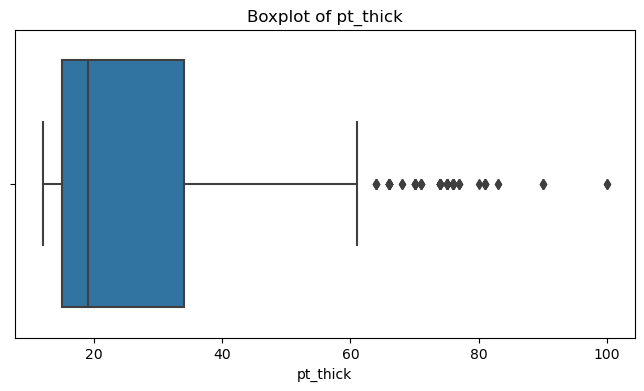

pt_width is Lower_bound in pt_width: 1600.0
pt_width is Upper_bound in pt_width: 4000.0


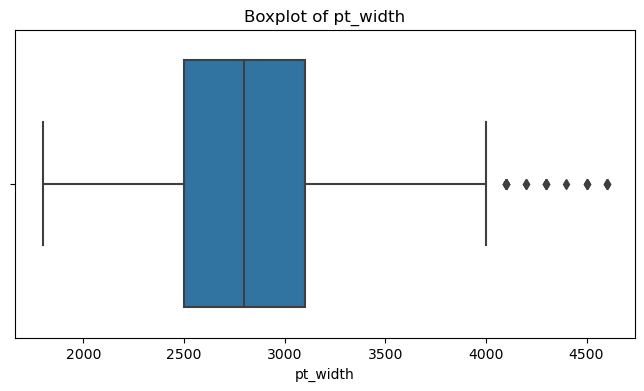

pt_length is Lower_bound in pt_length: -7025.0
pt_length is Upper_bound in pt_length: 82775.0


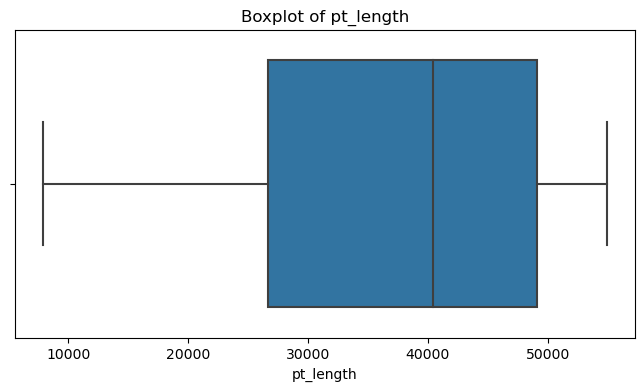

fur_heat_temp is Lower_bound in fur_heat_temp: 1090.5
fur_heat_temp is Upper_bound in fur_heat_temp: 1222.5


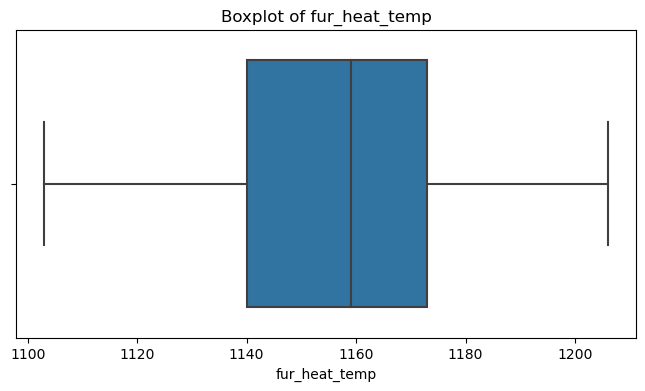

fur_heat_time is Lower_bound in fur_heat_time: 11.625
fur_heat_time is Upper_bound in fur_heat_time: 156.625


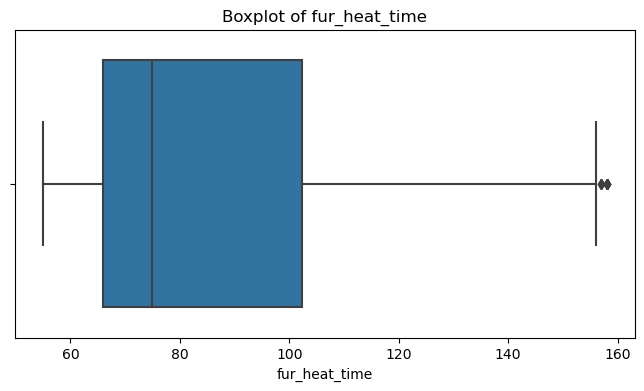

fur_soak_temp is Lower_bound in fur_soak_temp: 1093.375
fur_soak_temp is Upper_bound in fur_soak_temp: 1206.375


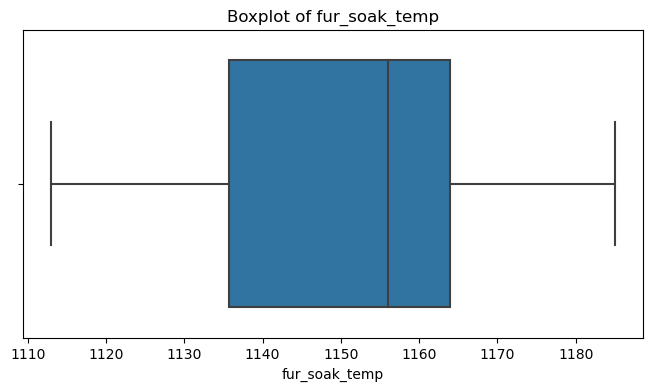

fur_soak_time is Lower_bound in fur_soak_time: 22.875
fur_soak_time is Upper_bound in fur_soak_time: 115.875


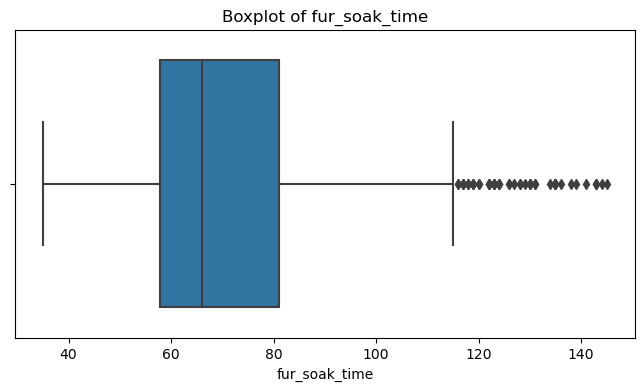

fur_total_time is Lower_bound in fur_total_time: 130.5
fur_total_time is Upper_bound in fur_total_time: 342.5


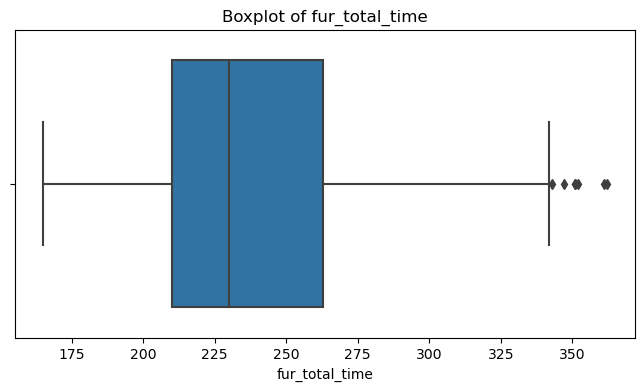

rolling_temp is Lower_bound in rolling_temp: 747.875
rolling_temp is Upper_bound in rolling_temp: 1136.875


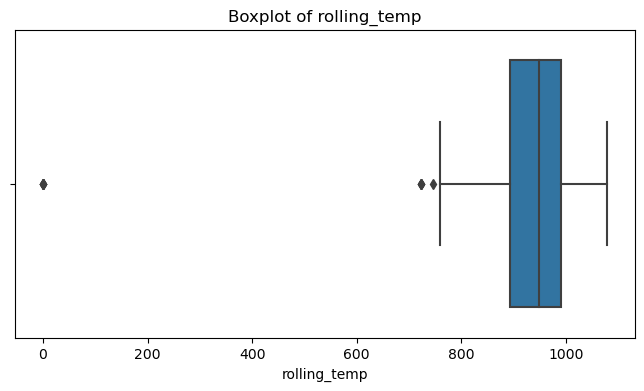

KeyError: 'descailing_count'

In [19]:
# 이상치 확인 코드, 4분위수 기준
# lower_bound과 upper_bound를 출력하고 이상치가 있는 데이터를 필터링한다.
# Box_plot 그림.

def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print(f"{column} is Lower_bound in {column}: {lower_bound}")
        print(f"{column} is Upper_bound in {column}: {upper_bound}")
        # 이상치가 있는 데이터를 필터링
        outlier_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outliers[column] = outlier_indices.tolist()

        # Boxplot 그리기
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()
    
    return outliers

# 사용 예시
columns_to_check = [
    'pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 
    'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 
    'fur_total_time', 'rolling_temp', 'descailing_count'
]

outliers = detect_outliers(df, columns_to_check)

# 각 열의 이상치 인덱스 출력
for column, [indices] in outliers.items():
    print(f"Outliers in {column}: {indices}")
